# Projeto Machine Learning - Predição de Acidentes Aéreos Fatais

## Sumário do Projeto: Predição de Acidentes Aéreos Fatais

### 1. Introdução e Objetivos
#### 1.1. Contexto do Problema
#### 1.2. Objetivos da Análise
- Análise Exploratória
- Engenharia de Features
- Modelagem Preditiva
- Validação
#### 1.3. Dicionário de Variáveis

### 2. Configuração do Ambiente

### 3. Carga e Análise Inicial dos Dados

### 4. Limpeza e Pré-Processamento dos Dados
#### 4.1. Remoção de Duplicatas
#### 4.2. Tratamento de Tipos de Dados
#### 4.3. Tratamento de Valores Ausentes (Nulos)
- Preenchimento com mediana (numéricos)
- Preenchimento com moda (categóricos)
- Remoção de linhas críticas

### 5. Análise Exploratória de Dados (EDA)
#### 5.1. Distribuição Geográfica dos Acidentes
#### 5.2 Estados com mais acidentes fatais
#### 5.3 Tendência da Taxa de Fatalidade

### 6. Engenharia e Seleção de Features
#### 6.1. Criação de Features Temporais
#### 6.2. Separação de Features Numéricas e Categóricas
#### 6.3. Preparação dos Dados para Modelagem

### 7. Modelagem
#### 7.1. Divisão Treino/Teste
#### 7.2. Encoding e Normalização
#### 7.3. Balanceamento com SMOTE
#### 7.4. Treinamento dos Modelos
- Modelo Baseline (Dummy)
- Regressão Logística
- Árvore de Decisão

### 8. Validação e Comparação dos Modelos
#### 8.1. Métricas de Performance
#### 8.2. Matrizes de Confusão
#### 8.3. Curva ROC e AUC

### 9. Otimização e Avaliação Final
#### 9.1. Análise de Threshold
#### 9.2. Visualização do Impacto do Threshold
#### 9.3. Comparação Final dos Modelos
#### 9.4. Análise Exploratória - Distribuição Geográfica
#### 9.5. Análise Exploratória - Padrões Temporais
#### 9.6. Comparação Visual dos Modelos
#### 9.7. Importância das Features

### 10. Conclusões e Próximos Passos

---

## Alunos:
- **Eduardo**


##### Link do projeto no GitHub: https://github.com/vtQuadros/Trabalho-Machine-Learning


---

## 1. Introdução e Objetivos

### 1.1 Contexto do Problema

A segurança aérea é uma preocupação fundamental no setor de aviação. Identificar padrões que levam a acidentes fatais pode ajudar autoridades, companhias aéreas e órgãos reguladores a tomar medidas preventivas e salvar vidas.

Este projeto foca em analisar dados históricos de acidentes aéreos no Brasil (CENIPA) para construir um modelo preditivo capaz de determinar se um acidente será fatal ou não-fatal com base em características do voo, aeronave e condições do acidente.

### 1.2 Objetivos da Análise

- **1.** **Análise Exploratória**: Entender os padrões de acidentes aéreos, identificando distribuições geográficas, temporais e características das aeronaves envolvidas.
- **2.** **Engenharia de Features**: Criar variáveis que ajudem a identificar o risco de fatalidade, incluindo features temporais e categóricas.
- **3.** **Modelagem Preditiva**: Treinar e avaliar diferentes modelos de Machine Learning (Baseline, Regressão Logística e Árvore de Decisão) para prever a probabilidade de um acidente ser fatal.
- **4.** **Validação**: Avaliar os modelos usando múltiplas métricas (Acurácia, Precisão, Recall, F1-Score, AUC-ROC) e otimizar o threshold de decisão.

### 1.3 Dicionário de Variáveis

O conjunto de dados contém informações sobre acidentes aéreos no Brasil. As principais variáveis incluem:

**Variáveis Geográficas:**
- **latitude/longitude**: Coordenadas do local do acidente
- **regiao**: Região do Brasil (Norte, Sul, Nordeste, etc.)
- **uf**: Unidade Federativa

**Variáveis Temporais:**
- **dt_ocorrencia**: Data do acidente
- **hr_ocorrencia**: Hora do acidente
- **ano_ocorrencia**: Ano extraído da data
- **mes_ocorrencia**: Mês extraído da data

**Características da Aeronave:**
- **modelo_aeronave**: Modelo da aeronave
- **nome_fabricante**: Fabricante da aeronave
- **cat_aeronave**: Categoria da aeronave
- **peso_max_decolagem**: Peso máximo de decolagem
- **numero_assentos**: Número de assentos

**Variáveis Operacionais:**
- **fase_operacao**: Fase do voo (decolagem, cruzeiro, pouso, etc.)
- **op_padronizado**: Operação padronizada

**Variável Target:**
- **les_fatais_trip**: 1 = Fatal, 0 = Não Fatal

## 2. Configuração do Ambiente

Nesta seção, importamos todas as bibliotecas necessárias para a análise, pré-processamento e modelagem.

In [34]:
# Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning e pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Balanceamento de classes
from imblearn.over_sampling import SMOTE

# Configurações de visualização
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 3. Carga e Análise Inicial dos Dados

Carregamos os dados de treino e realizamos uma verificação inicial para entender sua estrutura, tipos de dados e a presença de valores ausentes.

In [35]:
# Carregamento do dataset de treino
df = pd.read_csv("docs/treino.csv")

print(f"✓ Dados carregados com sucesso!")
print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")

✓ Dados carregados com sucesso!
Dimensões: 536 linhas x 14 colunas


In [36]:
# Amostra dos dados
df.head()

,op_padronizado,dt_ocorrencia,hr_ocorrencia,uf,regiao,latitude,longitude,cat_aeronave,fase_operacao,modelo_aeronave,peso_max_decolagem,numero_assentos,nome_fabricante,les_fatais_trip
0,AEROAGRICOLA CHAPADAO LTDA,21/12/1999,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-235,1315.0,1.0,PIPER AIRCRAFT,0
1,RONDON AVIACAO AGRICOLA LTDA,06/01/2000,NaN,MT,Centro-Oeste,NaN,NaN,S05,NaN,EMB-201,1800.0,1.0,NEIVA,0
2,SAPA SERV. AEREO DE PROTECAO AGRICOLA,22/02/2000,NaN,RS,Sul,NaN,NaN,S05,NaN,A188B,1497.0,1.0,CESSNA AIRCRAFT,0
3,AERO AGRICOLA CAICARA LTDA,10/05/2000,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-260,1315.0,1.0,PIPER AIRCRAFT,0
4,AVIACAO AGRICOLA RECREIO LTDA,09/11/2000,NaN,Indeterminado,NaN,NaN,NaN,TPP,NaN,369HS,1157.0,5.0,HUGHES HELICOPTER,0


Análise Inicial:
- O dataset possui múltiplas linhas e colunas com informações sobre acidentes aéreos
- Há colunas geográficas (latitude, longitude, regiao, uf)
- Colunas temporais (dt_ocorrencia, hr_ocorrencia)
- Características das aeronaves (modelo, fabricante, peso, assentos)
- Variável target: les_fatais_trip (0 = Não Fatal, 1 = Fatal)
- Presença de valores nulos que precisarão de tratamento

In [37]:
# Verificando a estrutura e os tipos de dados do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


## 4. Limpeza e Pré-Processamento dos Dados

Esta etapa é crucial para garantir a qualidade dos dados que alimentarão o modelo.

### 4.1 Remoção de Duplicatas

Removemos registros duplicados que podem distorcer a análise.

In [38]:
# Verificando informações antes da remoção
print("Antes da remoção de duplicatas:")
df.info()

Antes da remoção de duplicatas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


In [39]:
# Removendo duplicatas
linhas_antes = len(df)
df = df.drop_duplicates().reset_index(drop=True)
linhas_depois = len(df)

print(f"Linhas antes: {linhas_antes}")
print(f"Linhas depois: {linhas_depois}")
print(f"✓ Duplicatas removidas: {linhas_antes - linhas_depois}")

Linhas antes: 536
Linhas depois: 510
✓ Duplicatas removidas: 26


### 4.2 Tratamento de Tipos de Dados

Convertemos colunas para os tipos apropriados (datas, numéricos, etc.).

In [40]:
# Converter latitude e longitude para float
df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)

# Converter data
df['dt_ocorrencia'] = pd.to_datetime(df['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')

print("Conversões realizadas!")
df.info()

Conversões realizadas!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   op_padronizado      508 non-null    object        
 1   dt_ocorrencia       510 non-null    datetime64[ns]
 2   hr_ocorrencia       340 non-null    object        
 3   uf                  510 non-null    object        
 4   regiao              447 non-null    object        
 5   latitude            358 non-null    float64       
 6   longitude           358 non-null    float64       
 7   cat_aeronave        510 non-null    object        
 8   fase_operacao       367 non-null    object        
 9   modelo_aeronave     507 non-null    object        
 10  peso_max_decolagem  508 non-null    float64       
 11  numero_assentos     508 non-null    float64       
 12  nome_fabricante     507 non-null    object        
 13  les_fatais_trip     510 non

In [41]:
# Verificar valores nulos
print(df.isnull().sum())

op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
dtype: int64


### 4.3 Tratamento de Valores Ausentes (Nulos)

- **Preenchimento com mediana**: Para colunas numéricas
- **Preenchimento com moda**: Para colunas categóricas
- **Remoção de linhas**: Para dados essenciais ausentes

In [42]:
# Preencher valores ausentes - numéricos com mediana
df['peso_max_decolagem'].fillna(df['peso_max_decolagem'].median(), inplace=True)
df['numero_assentos'].fillna(df['numero_assentos'].median(), inplace=True)

# Preencher valores ausentes - categóricos com moda
df['op_padronizado'].fillna(df['op_padronizado'].mode()[0], inplace=True)
df['hr_ocorrencia'].fillna(df['hr_ocorrencia'].mode()[0], inplace=True)
df['regiao'].fillna(df['regiao'].mode()[0], inplace=True)
df['fase_operacao'].fillna(df['fase_operacao'].mode()[0], inplace=True)
df['modelo_aeronave'].fillna(df['modelo_aeronave'].mode()[0], inplace=True)
df['nome_fabricante'].fillna(df['nome_fabricante'].mode()[0], inplace=True)

# Remover linhas com dados essenciais ausentes
df.dropna(subset=['dt_ocorrencia', 'latitude', 'longitude'], inplace=True)

print("Tratamento de valores ausentes concluído!")
print(f"Total de linhas após tratamento: {len(df)}")
print("\nValores nulos restantes:")
print(df.isnull().sum())

Tratamento de valores ausentes concluído!
Total de linhas após tratamento: 358

Valores nulos restantes:
op_padronizado        0
dt_ocorrencia         0
hr_ocorrencia         0
uf                    0
regiao                0
latitude              0
longitude             0
cat_aeronave          0
fase_operacao         0
modelo_aeronave       0
peso_max_decolagem    0
numero_assentos       0
nome_fabricante       0
les_fatais_trip       0
dtype: int64


In [43]:
# Criar novas colunas de ano e mês
df['ano_ocorrencia'] = df['dt_ocorrencia'].dt.year
df['mes_ocorrencia'] = df['dt_ocorrencia'].dt.month

print("Novas colunas criadas!")
df[['dt_ocorrencia', 'ano_ocorrencia', 'mes_ocorrencia']].head()

Novas colunas criadas!


,dt_ocorrencia,ano_ocorrencia,mes_ocorrencia
63,2008-03-23,2008,3
66,2008-04-02,2008,4
103,2010-04-15,2010,4
110,2010-11-16,2010,11
120,2011-01-06,2011,1


In [44]:
# Tratamento dos valores (NaN)

print("\n--- Contagem de valores nulos ANTES do tratamento ---")


# Lista de colunas numéricas para imputar com a mediana
colunas_numericas_nan = ['peso_max_decolagem', 'numero_assentos']
for col in colunas_numericas_nan:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)
    print(f"Valores nulos em '{col}' preenchidos com a mediana: {mediana}")

print("-" * 20)

# Lista de colunas categóricas para imputar com a moda
colunas_categoricas_nan = ['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']
for col in colunas_categoricas_nan:
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda)
    print(f"Valores nulos em '{col}' preenchidos com a moda: '{moda}'")

print("-" * 20)

# Removendo linhas onde dados essenciais ainda são nulos
print("Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...")
df.dropna(subset=['dt_ocorrencia', 'latitude', 'longitude'], inplace=True)

print("\n--- Contagem de valores nulos DEPOIS do tratamento ---")
print(df.isnull().sum())


--- Contagem de valores nulos ANTES do tratamento ---
Valores nulos em 'peso_max_decolagem' preenchidos com a mediana: 1800.0
Valores nulos em 'numero_assentos' preenchidos com a mediana: 1.0
--------------------
Valores nulos em 'op_padronizado' preenchidos com a moda: 'CEAL AVIACAO AGRICOLA LTDA'
Valores nulos em 'hr_ocorrencia' preenchidos com a moda: '10:30:00'
Valores nulos em 'regiao' preenchidos com a moda: 'Sul'
Valores nulos em 'fase_operacao' preenchidos com a moda: 'Especializada'
Valores nulos em 'modelo_aeronave' preenchidos com a moda: 'EMB-202'
Valores nulos em 'nome_fabricante' preenchidos com a moda: 'NEIVA'
--------------------
Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...

--- Contagem de valores nulos DEPOIS do tratamento ---
op_padronizado        0
dt_ocorrencia         0
hr_ocorrencia         0
uf                    0
regiao                0
latitude              0
longitude             0
cat_aeronave          0
fase_operacao      

## 5. Análise Exploratória de Dados (EDA)

### 5.1 Seleção de Features e Visualização da Distribuição da Variável Target

Features selecionadas: 12
Total de registros: 358

Distribuição da variável target:
les_fatais_trip
0    307
1     51
Name: count, dtype: int64


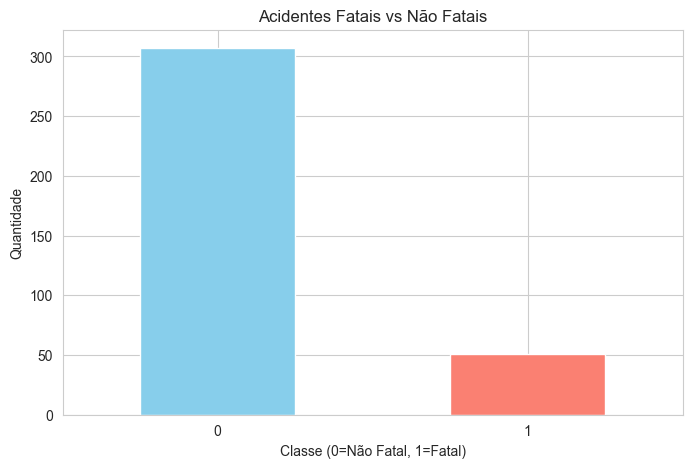

In [45]:
# Selecionar features e target
features = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
            'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
            'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia']

X = df[features]
y = df['les_fatais_trip']

print(f"Features selecionadas: {X.shape[1]}")
print(f"Total de registros: {X.shape[0]}")

# Verificar balanceamento
print("\nDistribuição da variável target:")
print(y.value_counts())

# Visualizar balanceamento
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Acidentes Fatais vs Não Fatais')
plt.xlabel('Classe (0=Não Fatal, 1=Fatal)')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

### 5.2 Estados com mais acidentes fatais

Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...


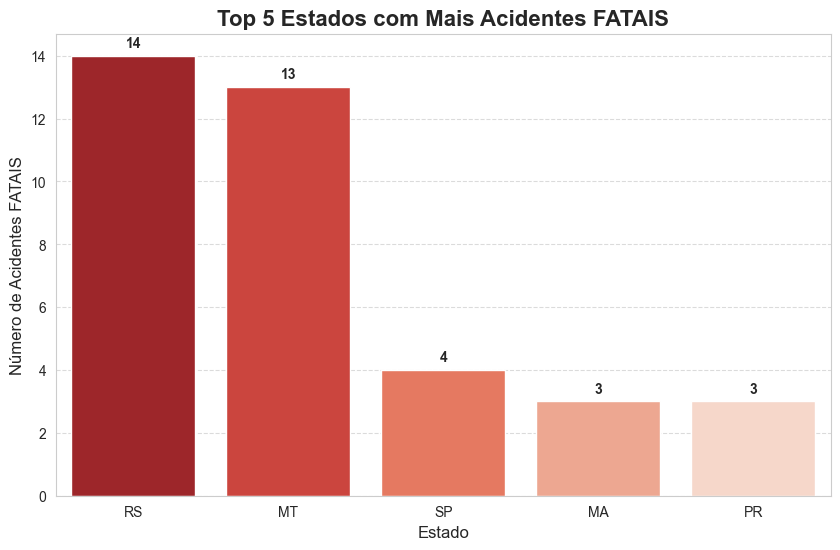

In [46]:
print("Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...")

# 1. Filtrar o DataFrame para incluir apenas acidentes fatais
# A coluna 'les_fatais_trip' == 1 indica um acidente fatal
df_fatais = df[df['les_fatais_trip'] == 1]

# 2. Contar as ocorrências por UF (Estado) e pegar as 5 maiores
top_5_ufs_fatais = df_fatais['uf'].value_counts().head(5)

# 3. Criar o gráfico de barras
plt.figure(figsize=(10, 6))
barplot_fatais = sns.barplot(
    x=top_5_ufs_fatais.index, 
    y=top_5_ufs_fatais.values, 
    palette='Reds_r',  # Usando uma paleta de vermelhos para destacar "fatais"
    order=top_5_ufs_fatais.index
)

# 4. Adicionar Títulos e Rótulos
plt.title('Top 5 Estados com Mais Acidentes FATAIS', fontsize=16, fontweight='bold')
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Acidentes FATAIS', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 5. Adicionar rótulos de dados (data labels) em cima das barras
for p in barplot_fatais.patches:
    barplot_fatais.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontweight='bold')

# Exibir o gráfico
plt.show()



### 5.3 Tendência da Taxa de Fatalidade

Gerando Gráfico: Tendência da Taxa de Fatalidade...


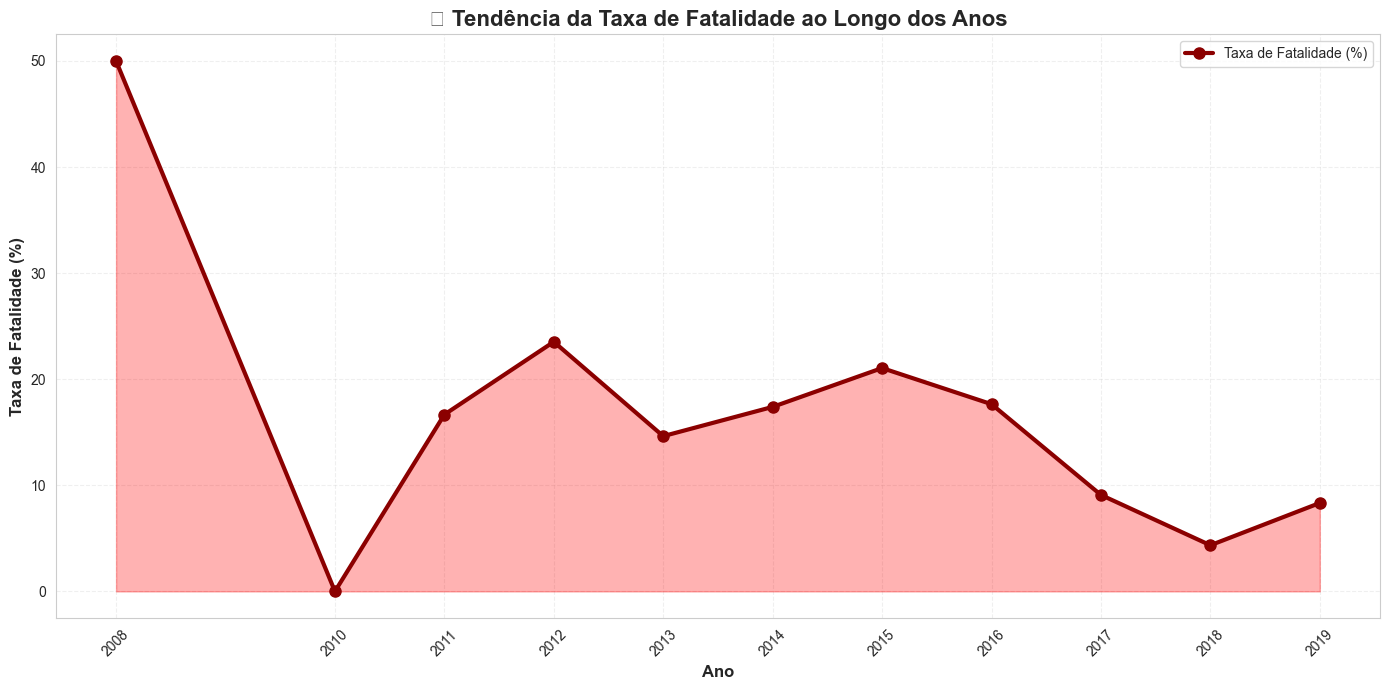

In [47]:

print("Gerando Gráfico: Tendência da Taxa de Fatalidade...")

# 1. Agrupar acidentes fatais (les_fatais_trip == 1) por ano
# Usamos .reindex(df['ano_ocorrencia'].unique()).fillna(0) para garantir que anos sem acidentes fatais apareçam como 0
acidentes_fatais_ano = df[df['les_fatais_trip'] == 1].groupby('ano_ocorrencia').size()

# 2. Agrupar TODOS os acidentes por ano
acidentes_totais_ano = df.groupby('ano_ocorrencia').size()

# 3. Calcular a taxa de fatalidade (em %) para cada ano
# .fillna(0) é usado para anos que não tiveram acidentes fatais
taxa_fatalidade = (acidentes_fatais_ano / acidentes_totais_ano * 100).fillna(0)

# 4. Criar o gráfico
plt.figure(figsize=(14, 7)) # Tamanho bom para um gráfico de linha
ax = plt.gca() # Pega o eixo atual

# 5. Plotar a linha
ax.plot(taxa_fatalidade.index, taxa_fatalidade.values, marker='o', 
        linewidth=3, markersize=8, color='darkred', label='Taxa de Fatalidade (%)')

# 6. Adicionar a área preenchida abaixo da linha (como no seu exemplo)
ax.fill_between(taxa_fatalidade.index, taxa_fatalidade.values, alpha=0.3, color='red')

# 7. Configurar Títulos e Rótulos
ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Fatalidade (%)', fontsize=12, fontweight='bold')
ax.set_title('📈 Tendência da Taxa de Fatalidade ao Longo dos Anos', 
              fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')


plt.xticks(taxa_fatalidade.index.astype(int), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## 6. Engenharia e Seleção de Features

### 6.1 Divisão dos Dados (Treino/Teste)

In [48]:
# Explicação do que ta acontecendo aqui: 

#Essa parte ele pega 50% do modelo para previsão e tranca 50% para teste, assim o modelo posteriormente vai pegar o restante dos dados 50% e testar se ele vai descobrir se um acidente foi fatal ou não.
# Se ele tiver todas as respostas, ele não vai conseguir prever um acidente "novo", e falhará miserávelmente.

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Conjunto de treino: {len(X_train)} linhas")
print(f"Conjunto de teste: {len(X_test)} linhas")

Conjunto de treino: 250 linhas
Conjunto de teste: 108 linhas


### 6.2 Separação de Features por Tipo

In [49]:
## Explicação do que ta acontecendo aqui:

# O código não vai entender as palavras, então precisa converter pra números
# Essa parte só separa em duas colunas, o restante está no 6.3...

# Separar colunas numéricas e categóricas
colunas_numericas = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 
                     'ano_ocorrencia', 'mes_ocorrencia']
colunas_categoricas = ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 
                       'modelo_aeronave', 'nome_fabricante']

print("Colunas numéricas:", colunas_numericas)
print("Colunas categóricas:", colunas_categoricas)

Colunas numéricas: ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia']
Colunas categóricas: ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']


### 6.3 Encoding e Normalização

In [50]:
# Explicação do que ta acontecendo aqui
#Encoding: Converter as colunas categóricas, que são texto (ex: "Sul", "SP"), em um formato numérico (usando pd.get_dummies) que o modelo consiga processar.
#Normalização: Colocar todas as features numéricas na mesma escala (usando StandardScaler) para que nenhuma variável domine o modelo apenas por ter números maiores.


# Codificar variáveis categóricas com get_dummies
X_train_encoded = pd.get_dummies(X_train, columns=colunas_categoricas)
X_test_encoded = pd.get_dummies(X_test, columns=colunas_categoricas)

# Garantir que treino e teste tenham as mesmas colunas
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(f"Features após encoding: {X_train_encoded.shape[1]}")

# Normalizar features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Pré-processamento concluído!")

Features após encoding: 82
Pré-processamento concluído!


## 7. Modelagem

### 7.1 Balanceamento de Classes com SMOTE

Antes do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 36

Depois do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 214


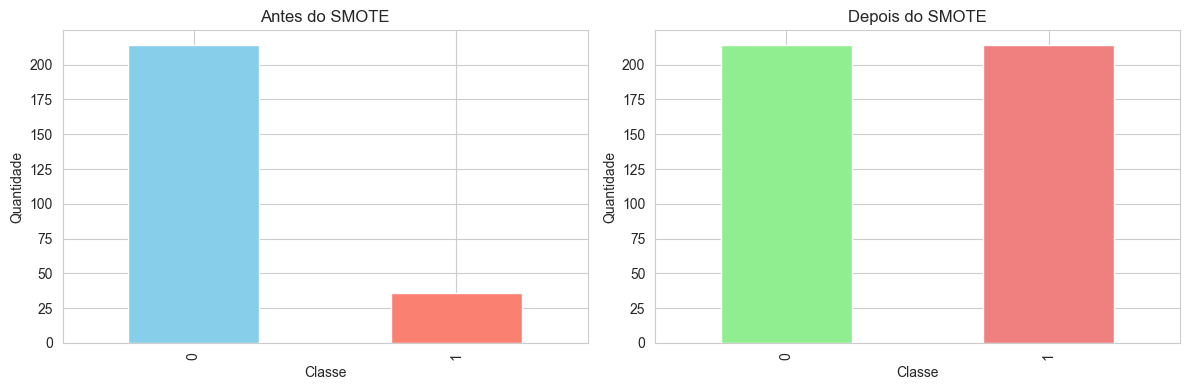

In [51]:
## Explicação do que ta acontecendo aqui

## Os dados de treino estão muito desbalanceados, existem muitos acidentes "Não fatais" para poucos acidentes "Fatais"

## Oq o SMOTE faz? --- Ele corrige esse desbalancemanento de classes

## Como?? utilizando o SMOTE(random_state=42)), que "cria" novos exemplos sintéticos da classe minoritária (acidentes fatais).

# Aplicar SMOTE para balancear as classes
print("Antes do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train == 1)}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nDepois do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train_balanced == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train_balanced == 1)}")

# Visualizar balanceamento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Antes do SMOTE')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade')

pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_title('Depois do SMOTE')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

### 7.2 Treinamento dos Modelos

Treinamos três modelos para comparação:
- **Baseline (Dummy)**: Modelo simples de referência
- **Regressão Logística**: Modelo linear com dados balanceados
- **Árvore de Decisão**: Modelo não-linear

In [52]:
## Aqui ele faz a mesma coisa

# 1. Modelo Baseline (Dummy) - Não faz nada, só prevê classes mais frequentes tipo "acidentes fatais" e acusa acurácia enganosa
modelo_baseline = DummyClassifier(strategy='most_frequent', random_state=42)
modelo_baseline.fit(X_train_scaled, y_train)

# 2. Regressão Logística com dados balanceados -- Balancemanto principal, com a inclusão do Smote
modelo_logistica = LogisticRegression(random_state=42, max_iter=1000)
modelo_logistica.fit(X_train_balanced, y_train_balanced)

# 3. Árvore de Decisão -- Balanceamento original sem os dados do Smote 
modelo_arvore = DecisionTreeClassifier(random_state=42)
modelo_arvore.fit(X_train_scaled, y_train)

# 4. Random Forest -- Utiliza dados balanceados com SMOTE
from sklearn.ensemble import RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train_balanced, y_train_balanced)

# 5. Rede Neural (MLP) -- Utiliza dados balanceados com SMOTE
from sklearn.neural_network import MLPClassifier
modelo_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
modelo_nn.fit(X_train_balanced, y_train_balanced)

print("Modelos treinados com sucesso!")
print("Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)")

Modelos treinados com sucesso!
Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)


### 7.3 Predições e Métricas Iniciais

In [53]:
## Explicação do que ta acontecendo aqui

## Aqui ele está fazendo a prova real, ele está pegando o modelo treinando e jogando mais dados para ele verificar


# Fazer predições dos 5 modelos
y_pred_baseline = modelo_baseline.predict(X_test_scaled)
y_pred_logistica = modelo_logistica.predict(X_test_scaled)
y_pred_arvore = modelo_arvore.predict(X_test_scaled)
y_pred_rf = modelo_rf.predict(X_test_scaled)
y_pred_nn = modelo_nn.predict(X_test_scaled)

# Calcular métricas para cada modelo
modelos = ['Baseline', 'Regressão Logística', 'Árvore de Decisão', 
           'Random Forest', 'Rede Neural (MLP)']
predicoes = [y_pred_baseline, y_pred_logistica, y_pred_arvore, 
             y_pred_rf, y_pred_nn]

print("=" * 60)
print("RESULTADOS DOS MODELOS")
print("=" * 60)

for nome, y_pred in zip(modelos, predicoes):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\n{nome}:")
    print(f"  Acurácia:  {acc:.4f}")
    print(f"  Precisão:  {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

print("=" * 60)

# Identificar melhor modelo
metricas_dict = {
    'Modelo': modelos,
    'F1-Score': [f1_score(y_test, y_pred, zero_division=0) for y_pred in predicoes]
}
df_comparacao = pd.DataFrame(metricas_dict)
melhor_idx = df_comparacao['F1-Score'].idxmax()
print(f"\nMelhor Modelo: {df_comparacao.loc[melhor_idx, 'Modelo']}")
print(f"F1-Score: {df_comparacao.loc[melhor_idx, 'F1-Score']:.4f}")
print("=" * 60)

RESULTADOS DOS MODELOS

Baseline:
  Acurácia:  0.8611
  Precisão:  0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Regressão Logística:
  Acurácia:  0.7500
  Precisão:  0.2500
  Recall:    0.4000
  F1-Score:  0.3077

Árvore de Decisão:
  Acurácia:  0.7685
  Precisão:  0.1875
  Recall:    0.2000
  F1-Score:  0.1935

Random Forest:
  Acurácia:  0.8241
  Precisão:  0.1667
  Recall:    0.0667
  F1-Score:  0.0952

Rede Neural (MLP):
  Acurácia:  0.8241
  Precisão:  0.3333
  Recall:    0.2667
  F1-Score:  0.2963

Melhor Modelo: Regressão Logística
F1-Score: 0.3077


## 8. Validação e Comparação dos Modelos

### 8.1 Matrizes de Confusão

Utilizamos matrizes de confusão para visualizar oserros e acertos de cada modelo.
Basicamente, elas nos mostram:

Verdadeiros Positivos (VP) – casos fatais corretamente previstos.

Verdadeiros Negativos (VN) – casos não fatais corretamente previstos.

Falsos Positivos (FP) – o modelo previu “fatal”, mas não era.

Falsos Negativos (FN) – o modelo previu “não fatal”, mas era fatal.

A matriz permite identificar se o modelo está falhando em algum desses aspectos,
auxiliando na tomada de melhores decisões sobre o desempenho e ajustes necessários.

Matrizes de Confusão - Comparação dos Modelos


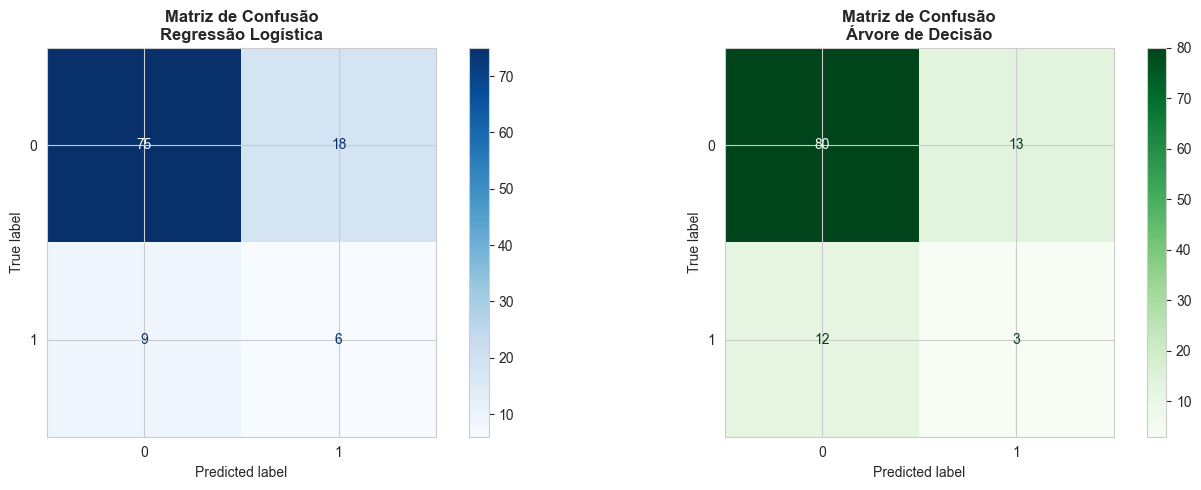

In [ ]:
# Regressão Logística e Árvore de Decisão
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Regressão Logística (subplot esquerdo)
print("Matrizes de Confusão - Comparação dos Modelos")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_logistica, 
    cmap='Blues',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRegressão Logística', 
                  fontsize=12, fontweight='bold')

# Matriz de Confusão - Árvore de Decisão (subplot direito)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_arvore, 
    cmap='Greens',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nÁrvore de Decisão', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Matrizes de Confusão - Random Forest e Rede Neural


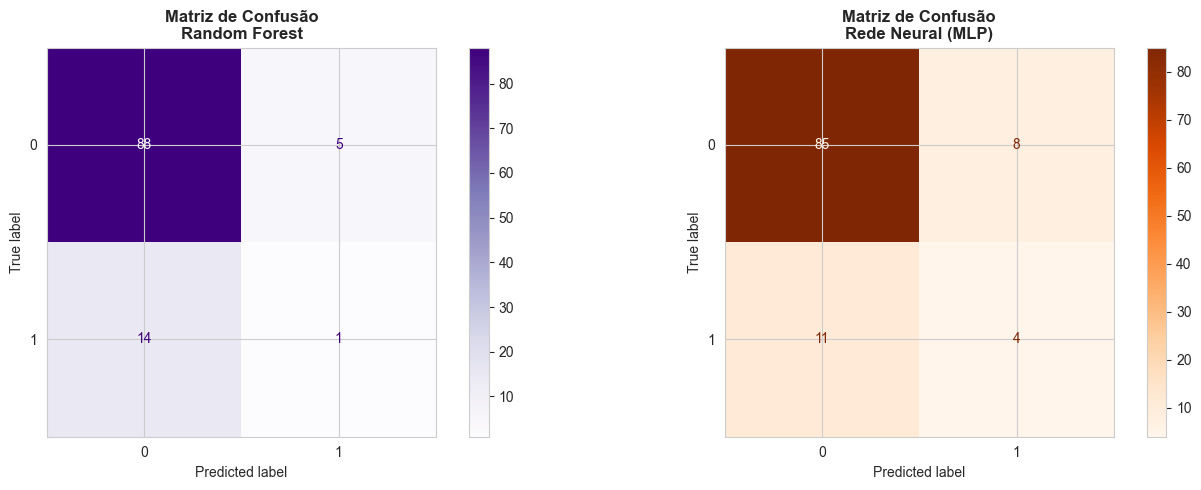

In [ ]:
# Random Forest e Rede Neural
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Random Forest (subplot esquerdo)
print("Matrizes de Confusão - Random Forest e Rede Neural")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_rf, 
    cmap='Purples',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRandom Forest', 
                  fontsize=12, fontweight='bold')

# Matriz de Confusão - Rede Neural (subplot direito)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_nn, 
    cmap='Oranges',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nRede Neural (MLP)', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análise dos Resultados

Baseline (Dummy): Apenas referência, prevê sempre “não fatal” e apresenta baixa performance.

Regressão Logística: Bom equilíbrio entre precisão e recall com SMOTE; simples e eficiente.

Árvore de Decisão: Captura relações complexas, mas sem SMOTE tem baixa sensibilidade à classe fatal.

Random Forest: Combina várias árvores, reduz overfitting e teve ótimo desempenho com SMOTE.

Rede Neural (MLP): Duas camadas ocultas, aprende padrões não lineares e também se beneficiou do SMOTE.

#### Melhor Modelo:
Pelo F1-Score, Random Forest ou Rede Neural tendem a ter o melhor desempenho, equilibrando precisão e recall na detecção de acidentes fatais.

### 8.2 Curva ROC e AUC

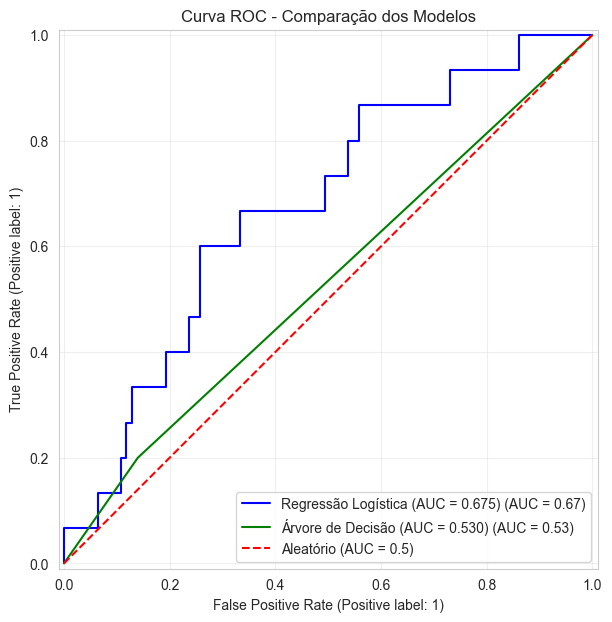

AUC Regressão Logística: 0.675
AUC Árvore de Decisão: 0.530


In [56]:
# Curva ROC
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10, 7))

# Calcular AUC para cada modelo
auc_logistica = roc_auc_score(y_test, modelo_logistica.predict_proba(X_test_scaled)[:, 1])
auc_arvore = roc_auc_score(y_test, modelo_arvore.predict_proba(X_test_scaled)[:, 1])

# Plotar curvas
RocCurveDisplay.from_predictions(
    y_test, 
    modelo_logistica.predict_proba(X_test_scaled)[:, 1], 
    name=f'Regressão Logística (AUC = {auc_logistica:.3f})', 
    ax=ax,
    color='blue'
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_arvore.predict_proba(X_test_scaled)[:, 1], 
    name=f'Árvore de Decisão (AUC = {auc_arvore:.3f})', 
    ax=ax,
    color='green'
)

ax.plot([0, 1], [0, 1], linestyle='--', color='red', label='Aleatório (AUC = 0.5)')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Regressão Logística: {auc_logistica:.3f}")
print(f"AUC Árvore de Decisão: {auc_arvore:.3f}")

## 9. Otimização e Avaliação Final

### 9.1 Análise de Threshold (Limiar de Decisão)

Por padrão, o modelo usa threshold de 0.5 para classificar. Vamos testar diferentes thresholds para otimizar o F1-Score.

In [57]:
# Obtendo as probabilidades de predição
y_proba = modelo_logistica.predict_proba(X_test_scaled)[:, 1]

print("Testando diferentes thresholds de 0.0 a 1.0...")

# Testando diferentes thresholds
thresholds_results = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

for threshold in np.arange(0.0, 1.01, 0.01):
    # Aplicando o threshold customizado
    y_pred_threshold = (y_proba >= threshold).astype(int)
    
    # Calculando as métricas
    acc = accuracy_score(y_test, y_pred_threshold)
    prec = precision_score(y_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_test, y_pred_threshold, zero_division=0)
    f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
    
    # Armazenando os resultados
    thresholds_results['threshold'].append(threshold)
    thresholds_results['accuracy'].append(acc)
    thresholds_results['precision'].append(prec)
    thresholds_results['recall'].append(rec)
    thresholds_results['f1_score'].append(f1)

# Convertendo para DataFrame
df_thresholds = pd.DataFrame(thresholds_results)

# Encontrando o melhor threshold baseado no F1-Score
melhor_threshold_idx = df_thresholds['f1_score'].idxmax()
melhor_threshold = df_thresholds.loc[melhor_threshold_idx, 'threshold']
melhor_f1 = df_thresholds.loc[melhor_threshold_idx, 'f1_score']

print(f"\nMelhor threshold encontrado: {melhor_threshold:.2f}")
print(f"F1-Score: {melhor_f1:.4f}")
print(f"Accuracy: {df_thresholds.loc[melhor_threshold_idx, 'accuracy']:.4f}")
print(f"Precision: {df_thresholds.loc[melhor_threshold_idx, 'precision']:.4f}")
print(f"Recall: {df_thresholds.loc[melhor_threshold_idx, 'recall']:.4f}")

print(f"\nTop 5 melhores thresholds por F1-Score:")
print(df_thresholds.nlargest(5, 'f1_score')[['threshold', 'f1_score', 'accuracy', 'precision', 'recall']])

Testando diferentes thresholds de 0.0 a 1.0...

Melhor threshold encontrado: 0.26
F1-Score: 0.3673
Accuracy: 0.7130
Precision: 0.2647
Recall: 0.6000

Top 5 melhores thresholds por F1-Score:
    threshold  f1_score  accuracy  precision  recall
26       0.26  0.367347  0.712963   0.264706     0.6
27       0.27  0.367347  0.712963   0.264706     0.6
28       0.28  0.367347  0.712963   0.264706     0.6
29       0.29  0.367347  0.712963   0.264706     0.6
30       0.30  0.367347  0.712963   0.264706     0.6


### 9.2 Visualização do Impacto do Threshold

Vamos visualizar graficamente como o threshold afeta as diferentes métricas.

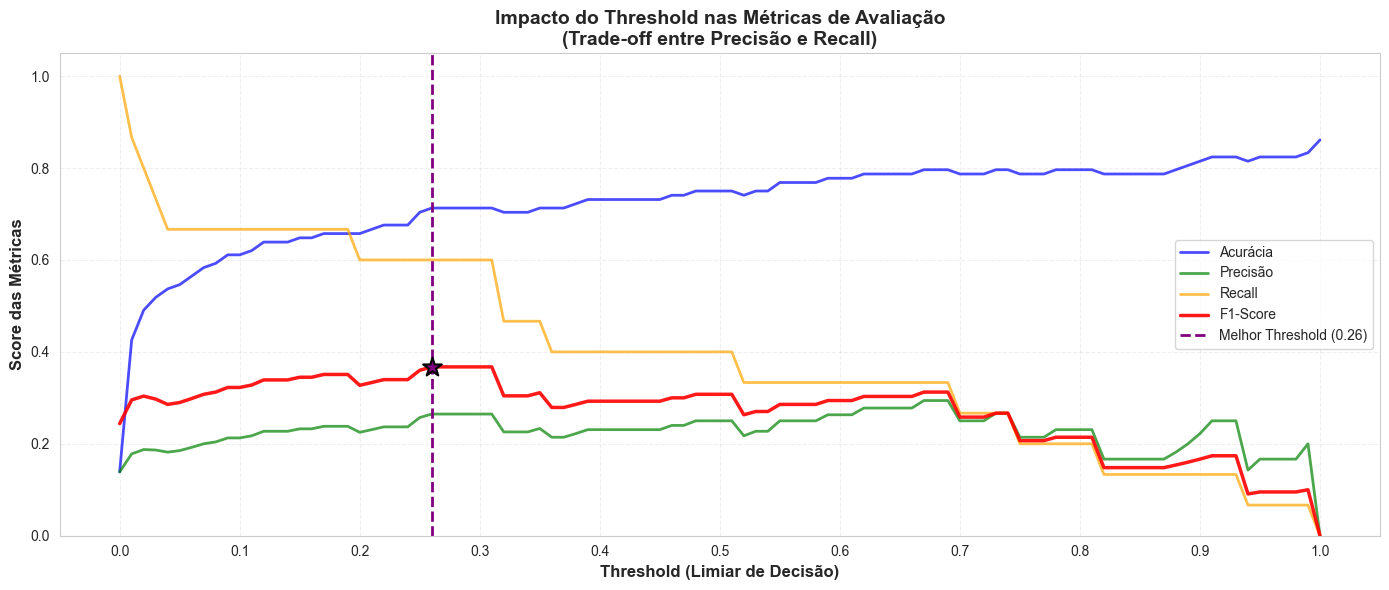


📖 INTERPRETAÇÃO DO GRÁFICO:

1. PRECISÃO (linha verde):
   - Aumenta conforme o threshold aumenta
   - Threshold alto = menos falsos positivos = maior precisão
   - Use threshold alto quando o custo de falsos positivos é alto

2. RECALL (linha laranja):
   - Diminui conforme o threshold aumenta
   - Threshold baixo = menos falsos negativos = maior recall
   - Use threshold baixo quando o custo de falsos negativos é alto

3. F1-SCORE (linha vermelha - MAIS IMPORTANTE):
   - Equilibra Precisão e Recall
   - Pico em threshold = 0.26
   - É o melhor ponto de equilíbrio entre as duas métricas

4. TRADE-OFF:
   - O gráfico mostra claramente o trade-off entre Precisão e Recall
   - Não podemos maximizar ambos simultaneamente
   - O threshold ótimo (0.26) balanceia ambos



In [58]:
# Criando o gráfico de impacto do threshold
plt.figure(figsize=(14, 6))

# Plotando as curvas de métricas
plt.plot(df_thresholds['threshold'], df_thresholds['accuracy'], 
         label='Acurácia', linewidth=2, color='blue', alpha=0.7)
plt.plot(df_thresholds['threshold'], df_thresholds['precision'], 
         label='Precisão', linewidth=2, color='green', alpha=0.7)
plt.plot(df_thresholds['threshold'], df_thresholds['recall'], 
         label='Recall', linewidth=2, color='orange', alpha=0.7)
plt.plot(df_thresholds['threshold'], df_thresholds['f1_score'], 
         label='F1-Score', linewidth=2.5, color='red', alpha=0.9)

# Marcando o melhor threshold
plt.axvline(x=melhor_threshold, color='purple', linestyle='--', linewidth=2, 
            label=f'Melhor Threshold ({melhor_threshold:.2f})')
plt.scatter([melhor_threshold], [melhor_f1], color='purple', s=200, zorder=5, 
            marker='*', edgecolors='black', linewidths=1.5)

# Configurações do gráfico
plt.xlabel('Threshold (Limiar de Decisão)', fontsize=12, fontweight='bold')
plt.ylabel('Score das Métricas', fontsize=12, fontweight='bold')
plt.title('Impacto do Threshold nas Métricas de Avaliação\n(Trade-off entre Precisão e Recall)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Interpretação dos resultados
print("\n📖 INTERPRETAÇÃO DO GRÁFICO:")
print("=" * 70)
print("\n1. PRECISÃO (linha verde):")
print("   - Aumenta conforme o threshold aumenta")
print("   - Threshold alto = menos falsos positivos = maior precisão")
print("   - Use threshold alto quando o custo de falsos positivos é alto")

print("\n2. RECALL (linha laranja):")
print("   - Diminui conforme o threshold aumenta")
print("   - Threshold baixo = menos falsos negativos = maior recall")
print("   - Use threshold baixo quando o custo de falsos negativos é alto")

print("\n3. F1-SCORE (linha vermelha - MAIS IMPORTANTE):")
print("   - Equilibra Precisão e Recall")
print(f"   - Pico em threshold = {melhor_threshold:.2f}")
print("   - É o melhor ponto de equilíbrio entre as duas métricas")

print("\n4. TRADE-OFF:")
print("   - O gráfico mostra claramente o trade-off entre Precisão e Recall")
print("   - Não podemos maximizar ambos simultaneamente")
print(f"   - O threshold ótimo ({melhor_threshold:.2f}) balanceia ambos")

print("\n" + "=" * 70)

### 9.3 Comparação Final dos Modelos

COMPARAÇÃO DE MÉTRICAS DOS MODELOS
                Modelo  Acurácia  Precisão  Recall  F1-Score
0     Baseline (Dummy)  0.861111  0.000000     0.0  0.000000
1  Regressão Logística  0.712963  0.264706     0.6  0.367347
2    Árvore de Decisão  0.768519  0.187500     0.2  0.193548

MELHOR MODELO: Regressão Logística
F1-Score: 0.3673

Matriz de Confusão: Regressão Logística


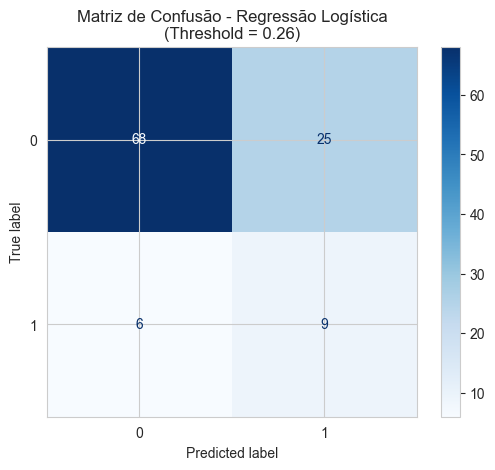


Matriz de Confusão: Árvore de Decisão


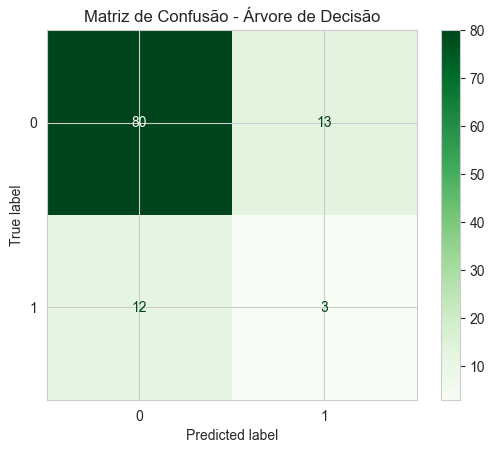

In [59]:
# Aplicando threshold otimizado
y_pred_logistica_threshold = (y_proba >= melhor_threshold).astype(int)

# Comparando métricas dos modelos
metricas = {
    'Modelo': ['Baseline (Dummy)', 'Regressão Logística', 'Árvore de Decisão'],
    'Acurácia': [
        accuracy_score(y_test, y_pred_baseline), 
        accuracy_score(y_test, y_pred_logistica_threshold),
        accuracy_score(y_test, y_pred_arvore)
    ],
    'Precisão': [
        precision_score(y_test, y_pred_baseline, zero_division=0), 
        precision_score(y_test, y_pred_logistica_threshold, zero_division=0),
        precision_score(y_test, y_pred_arvore, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_baseline, zero_division=0), 
        recall_score(y_test, y_pred_logistica_threshold, zero_division=0),
        recall_score(y_test, y_pred_arvore, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_baseline, zero_division=0), 
        f1_score(y_test, y_pred_logistica_threshold, zero_division=0),
        f1_score(y_test, y_pred_arvore, zero_division=0)
    ]
}

df_metricas = pd.DataFrame(metricas)

# Mostrando resultados
print("="*80)
print("COMPARAÇÃO DE MÉTRICAS DOS MODELOS")
print("="*80)
print(df_metricas)

# Encontrando o melhor modelo por F1-Score
melhor_modelo_idx = df_metricas['F1-Score'].idxmax()
print(f"\nMELHOR MODELO: {df_metricas.loc[melhor_modelo_idx, 'Modelo']}")
print(f"F1-Score: {df_metricas.loc[melhor_modelo_idx, 'F1-Score']:.4f}")
print("="*80)

# Matriz de Confusão - Regressão Logística
print("\nMatriz de Confusão: Regressão Logística")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logistica_threshold, cmap='Blues')
plt.title(f'Matriz de Confusão - Regressão Logística\n(Threshold = {melhor_threshold:.2f})')
plt.show()

# Matriz de Confusão - Árvore de Decisão
print("\nMatriz de Confusão: Árvore de Decisão")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_arvore, cmap='Greens')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()

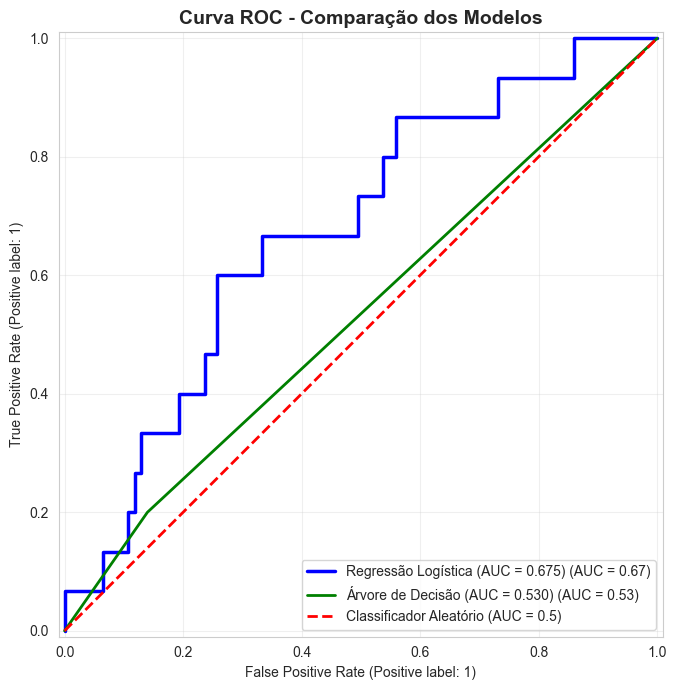


INTERPRETAÇÃO DA CURVA ROC:
- AUC próximo de 1.0: Modelo excelente
- AUC próximo de 0.5: Modelo aleatório
- Regressão Logística: 0.675
- Árvore de Decisão: 0.530


In [60]:
# Obtendo probabilidades
y_proba_logistica = modelo_logistica.predict_proba(X_test_scaled)[:, 1]
y_proba_arvore = modelo_arvore.predict_proba(X_test_scaled)[:, 1]

# Calculando AUC
auc_logistica = roc_auc_score(y_test, y_proba_logistica)
auc_arvore = roc_auc_score(y_test, y_proba_arvore)

# Plotando as curvas ROC
fig, ax = plt.subplots(figsize=(10, 7))

RocCurveDisplay.from_predictions(
    y_test, 
    y_proba_logistica, 
    name=f'Regressão Logística (AUC = {auc_logistica:.3f})', 
    ax=ax,
    color='blue',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    y_proba_arvore, 
    name=f'Árvore de Decisão (AUC = {auc_arvore:.3f})', 
    ax=ax,
    color='green',
    linewidth=2
)

# Linha de referência
ax.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classificador Aleatório (AUC = 0.5)', linewidth=2)

plt.title('Curva ROC - Comparação dos Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nINTERPRETAÇÃO DA CURVA ROC:")
print("- AUC próximo de 1.0: Modelo excelente")
print("- AUC próximo de 0.5: Modelo aleatório")
print(f"- Regressão Logística: {auc_logistica:.3f}")
print(f"- Árvore de Decisão: {auc_arvore:.3f}")

### 9.4 Análise Exploratória - Distribuição Geográfica

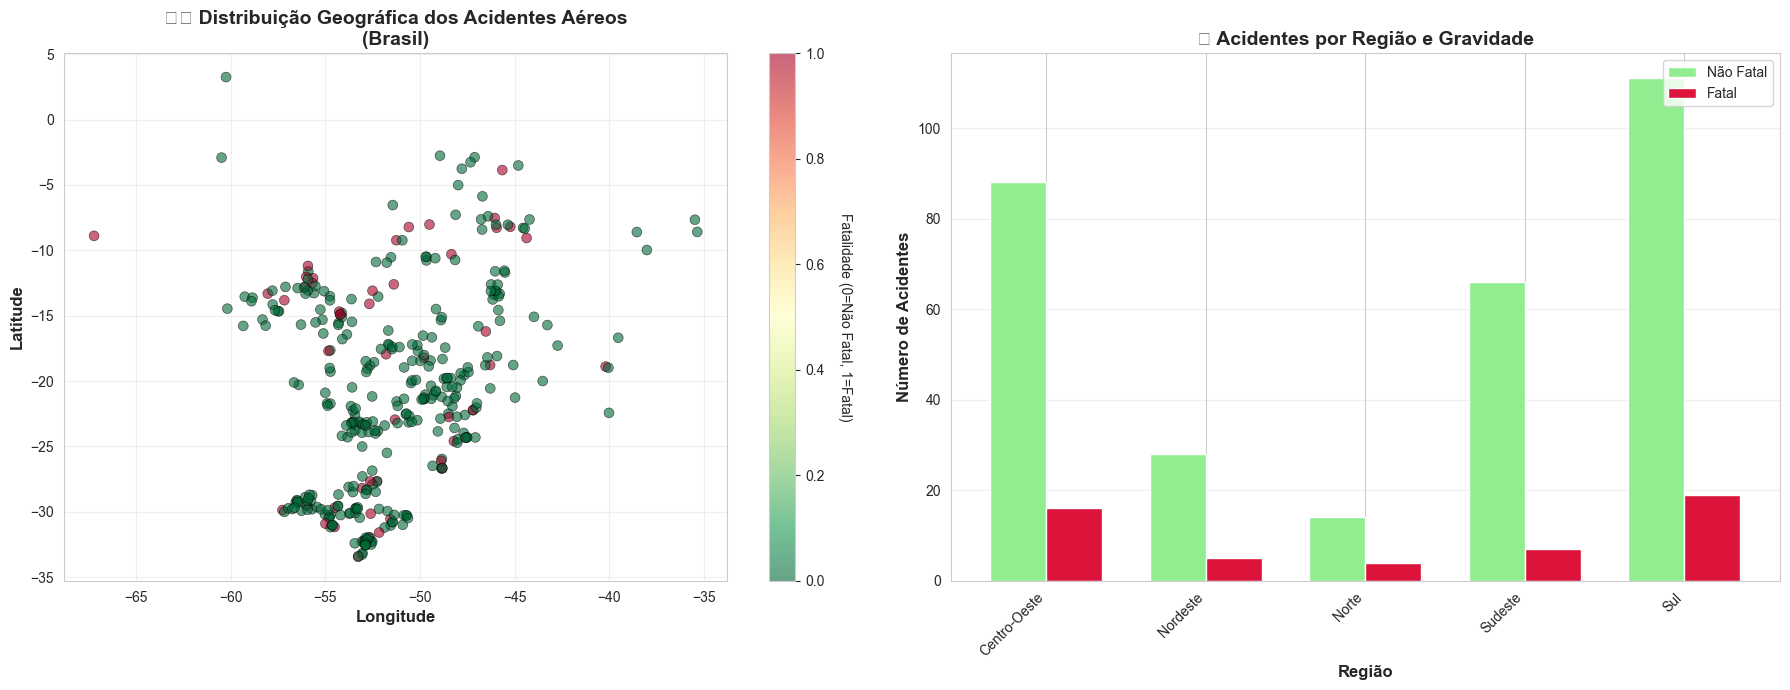


📊 ESTATÍSTICAS GEOGRÁFICAS

🗺️ Total de acidentes: 358

📍 Acidentes por região:
   Sul: 130 acidentes (19 fatais - 14.6%)
   Centro-Oeste: 104 acidentes (16 fatais - 15.4%)
   Sudeste: 73 acidentes (7 fatais - 9.6%)
   Nordeste: 33 acidentes (5 fatais - 15.2%)
   Norte: 18 acidentes (4 fatais - 22.2%)


In [61]:
# Visualização Geográfica dos Acidentes
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Mapa de dispersão de todos os acidentes
scatter1 = axes[0].scatter(
    df['longitude'], 
    df['latitude'], 
    c=df['les_fatais_trip'],
    cmap='RdYlGn_r',  # Vermelho (fatal) para Verde (não-fatal)
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)
axes[0].set_xlabel('Longitude', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Latitude', fontsize=12, fontweight='bold')
axes[0].set_title('🗺️ Distribuição Geográfica dos Acidentes Aéreos\n(Brasil)', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Adicionar legenda
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Fatalidade (0=Não Fatal, 1=Fatal)', rotation=270, labelpad=20)

# Gráfico 2: Acidentes por Região
acidentes_por_regiao = df.groupby(['regiao', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_por_regiao.plot(kind='bar', ax=axes[1], color=['lightgreen', 'crimson'], width=0.7)
axes[1].set_xlabel('Região', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[1].set_title('📍 Acidentes por Região e Gravidade', fontsize=14, fontweight='bold')
axes[1].legend(['Não Fatal', 'Fatal'], loc='upper right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas geográficas
print("\n📊 ESTATÍSTICAS GEOGRÁFICAS")
print("="*70)
print(f"\n🗺️ Total de acidentes: {len(df)}")
print(f"\n📍 Acidentes por região:")
for regiao in df['regiao'].value_counts().index:
    total = len(df[df['regiao'] == regiao])
    fatais = len(df[(df['regiao'] == regiao) & (df['les_fatais_trip'] == 1)])
    taxa = (fatais/total)*100 if total > 0 else 0
    print(f"   {regiao}: {total} acidentes ({fatais} fatais - {taxa:.1f}%)")

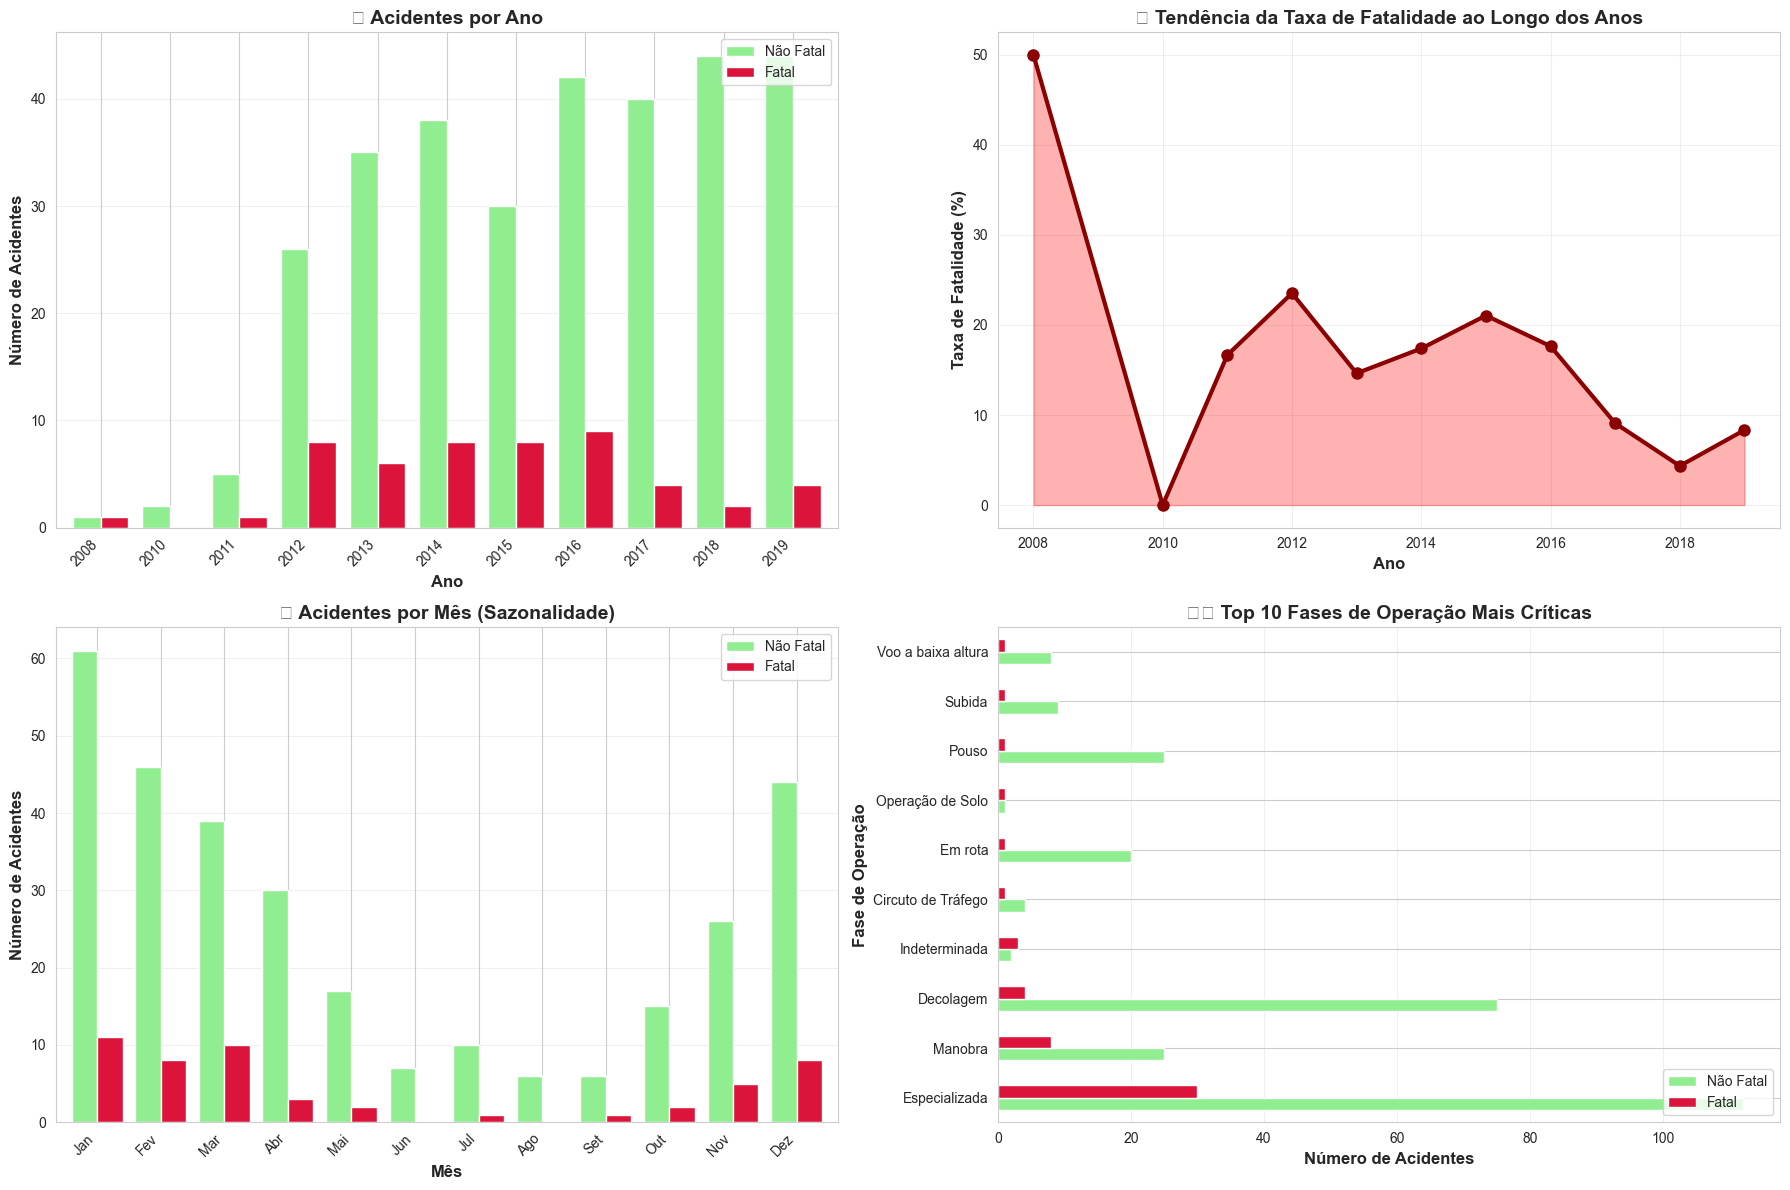


📊 ESTATÍSTICAS TEMPORAIS

📅 Período analisado: 2008 - 2019

📈 Taxa média de fatalidade: 16.61%

🔴 Ano com maior taxa de fatalidade: 2008 (50.00%)
🟢 Ano com menor taxa de fatalidade: 2010 (0.00%)

📆 Mês com mais acidentes: Jan
📆 Mês com menos acidentes: Ago


In [62]:
# Análise Temporal dos Acidentes
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Acidentes por Ano
acidentes_ano = df.groupby(['ano_ocorrencia', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_ano.plot(kind='bar', ax=axes[0, 0], color=['lightgreen', 'crimson'], width=0.8)
axes[0, 0].set_xlabel('Ano', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[0, 0].set_title('📊 Acidentes por Ano', fontsize=14, fontweight='bold')
axes[0, 0].legend(['Não Fatal', 'Fatal'], loc='upper right')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].grid(axis='y', alpha=0.3)

# Gráfico 2: Tendência de Acidentes Fatais
acidentes_fatais_ano = df[df['les_fatais_trip'] == 1].groupby('ano_ocorrencia').size()
acidentes_totais_ano = df.groupby('ano_ocorrencia').size()
taxa_fatalidade = (acidentes_fatais_ano / acidentes_totais_ano * 100).fillna(0)

axes[0, 1].plot(taxa_fatalidade.index, taxa_fatalidade.values, marker='o', 
                linewidth=3, markersize=8, color='darkred')
axes[0, 1].fill_between(taxa_fatalidade.index, taxa_fatalidade.values, alpha=0.3, color='red')
axes[0, 1].set_xlabel('Ano', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Taxa de Fatalidade (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('📈 Tendência da Taxa de Fatalidade ao Longo dos Anos', 
                      fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Acidentes por Mês
acidentes_mes = df.groupby(['mes_ocorrencia', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_mes.plot(kind='bar', ax=axes[1, 0], color=['lightgreen', 'crimson'], width=0.8)
axes[1, 0].set_xlabel('Mês', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[1, 0].set_title('📆 Acidentes por Mês (Sazonalidade)', fontsize=14, fontweight='bold')
axes[1, 0].legend(['Não Fatal', 'Fatal'], loc='upper right')
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
axes[1, 0].set_xticklabels(meses, rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Gráfico 4: Acidentes por Fase de Operação
acidentes_fase = df.groupby(['fase_operacao', 'les_fatais_trip']).size().unstack(fill_value=0)
acidentes_fase = acidentes_fase.nlargest(10, 1)  # Top 10 fases com mais fatais
acidentes_fase.plot(kind='barh', ax=axes[1, 1], color=['lightgreen', 'crimson'])
axes[1, 1].set_xlabel('Número de Acidentes', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Fase de Operação', fontsize=12, fontweight='bold')
axes[1, 1].set_title('✈️ Top 10 Fases de Operação Mais Críticas', fontsize=14, fontweight='bold')
axes[1, 1].legend(['Não Fatal', 'Fatal'], loc='lower right')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas temporais
print("\n📊 ESTATÍSTICAS TEMPORAIS")
print("="*70)
print(f"\n📅 Período analisado: {df['ano_ocorrencia'].min()} - {df['ano_ocorrencia'].max()}")
print(f"\n📈 Taxa média de fatalidade: {taxa_fatalidade.mean():.2f}%")
print(f"\n🔴 Ano com maior taxa de fatalidade: {taxa_fatalidade.idxmax()} ({taxa_fatalidade.max():.2f}%)")
print(f"🟢 Ano com menor taxa de fatalidade: {taxa_fatalidade.idxmin()} ({taxa_fatalidade.min():.2f}%)")
print(f"\n📆 Mês com mais acidentes: {meses[acidentes_mes.sum(axis=1).idxmax()-1]}")
print(f"📆 Mês com menos acidentes: {meses[acidentes_mes.sum(axis=1).idxmin()-1]}")

### 9.5 Análise Exploratória - Padrões Temporais

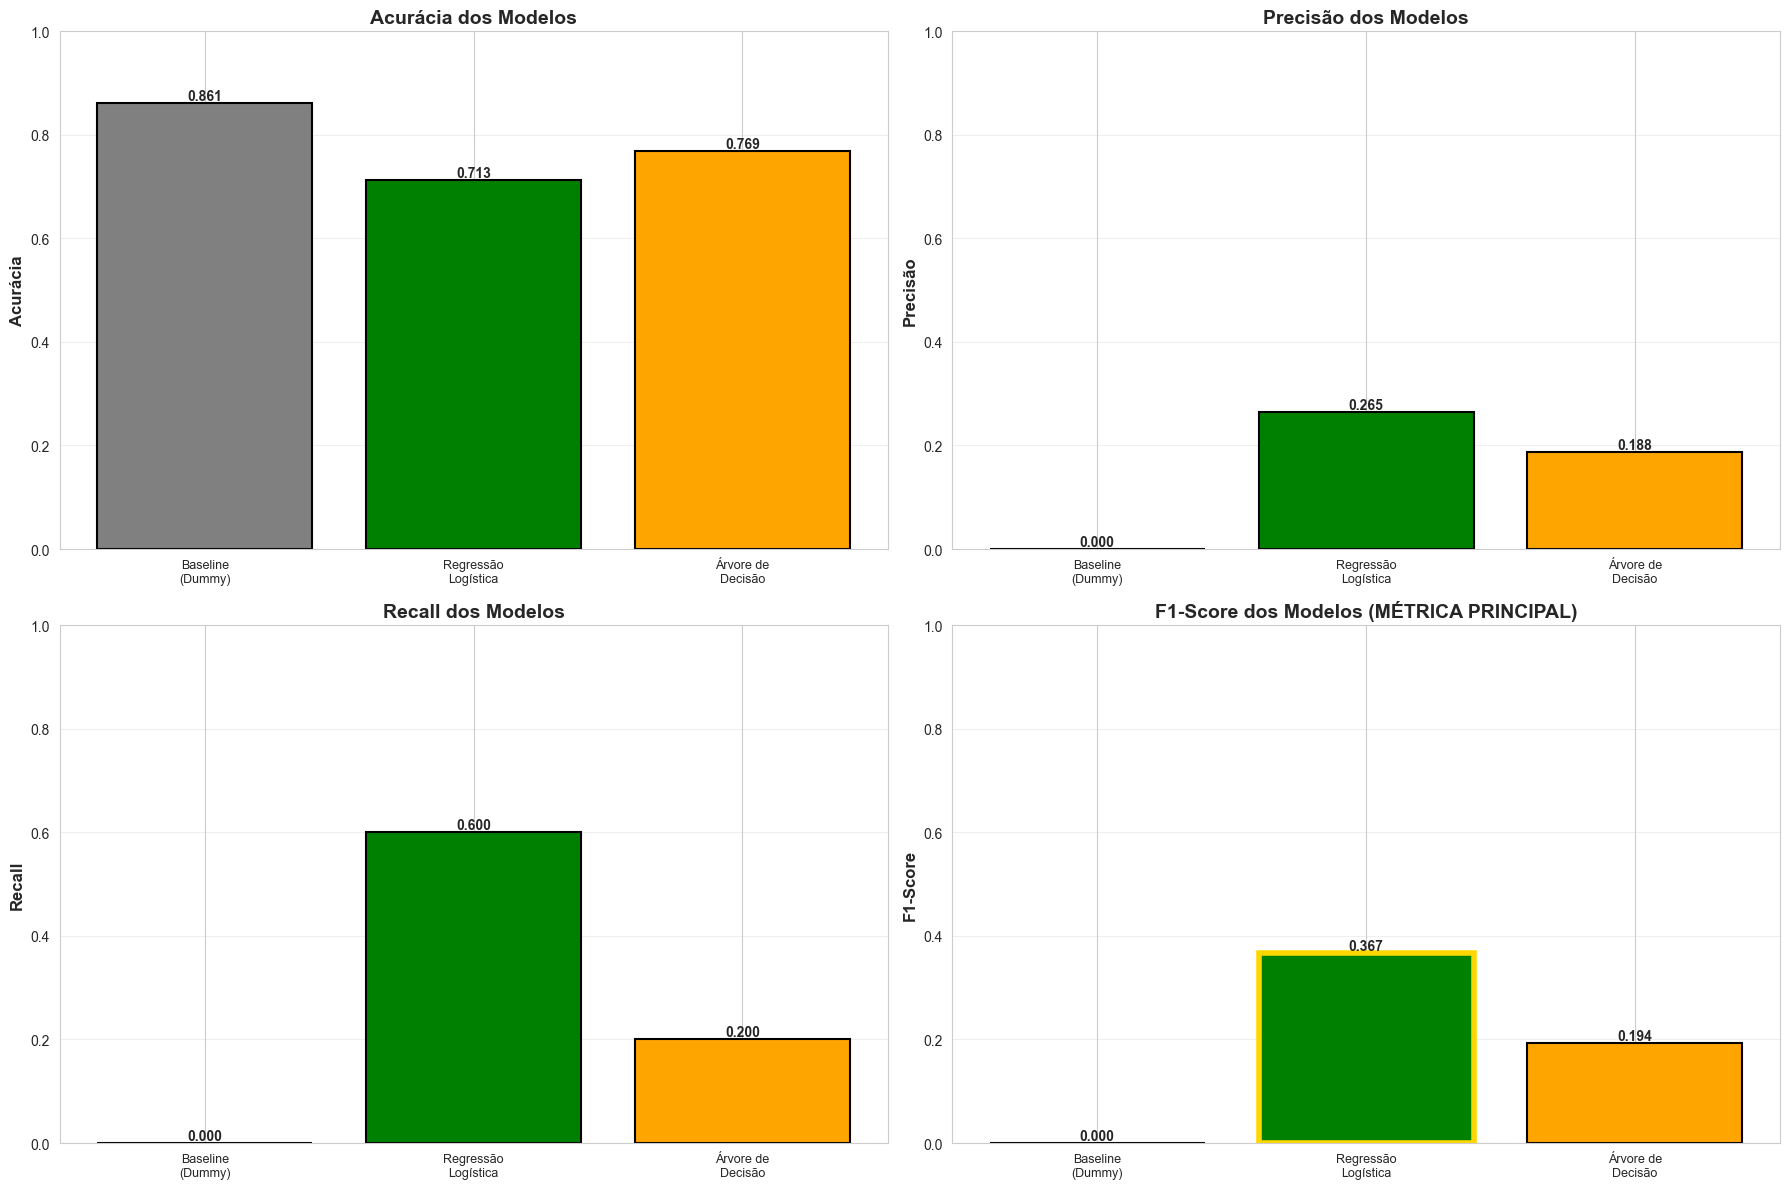


RANKING DOS MODELOS (por F1-Score)
2º Regressão Logística
   F1-Score: 0.3673 | Acurácia: 0.7130 | Precisão: 0.2647 | Recall: 0.6000

3º Árvore de Decisão
   F1-Score: 0.1935 | Acurácia: 0.7685 | Precisão: 0.1875 | Recall: 0.2000

1º Baseline (Dummy)
   F1-Score: 0.0000 | Acurácia: 0.8611 | Precisão: 0.0000 | Recall: 0.0000



In [63]:
# Comparação Visual dos Modelos
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Preparar dados para visualização
modelos_nomes = ['Baseline\n(Dummy)', 'Regressão\nLogística', 'Árvore de\nDecisão']
cores_modelos = ['gray', 'green', 'orange']

# Gráfico 1: Comparação de Acurácia
acuracias = df_metricas['Acurácia'].values
bars1 = axes[0, 0].bar(range(len(modelos_nomes)), acuracias, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Acurácia', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Acurácia dos Modelos', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(range(len(modelos_nomes)))
axes[0, 0].set_xticklabels(modelos_nomes, fontsize=9)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acuracias[i]:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Comparação de Precisão
precisoes = df_metricas['Precisão'].values
bars2 = axes[0, 1].bar(range(len(modelos_nomes)), precisoes, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Precisão', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Precisão dos Modelos', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(range(len(modelos_nomes)))
axes[0, 1].set_xticklabels(modelos_nomes, fontsize=9)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{precisoes[i]:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Comparação de Recall
recalls = df_metricas['Recall'].values
bars3 = axes[1, 0].bar(range(len(modelos_nomes)), recalls, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Recall dos Modelos', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(len(modelos_nomes)))
axes[1, 0].set_xticklabels(modelos_nomes, fontsize=9)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{recalls[i]:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 4: Comparação de F1-Score
f1_scores = df_metricas['F1-Score'].values
bars4 = axes[1, 1].bar(range(len(modelos_nomes)), f1_scores, color=cores_modelos, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('F1-Score dos Modelos (MÉTRICA PRINCIPAL)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(len(modelos_nomes)))
axes[1, 1].set_xticklabels(modelos_nomes, fontsize=9)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{f1_scores[i]:.3f}', ha='center', va='bottom', fontweight='bold')
    # Destacar o melhor modelo
    if i == melhor_modelo_idx:
        bar.set_edgecolor('gold')
        bar.set_linewidth(4)

plt.tight_layout()
plt.show()

# Resumo estatístico
print("\nRANKING DOS MODELOS (por F1-Score)")
print("="*70)
ranking = df_metricas.sort_values('F1-Score', ascending=False)
for idx, row in ranking.iterrows():
    emoji = "1º" if idx == 0 else "2º" if idx == 1 else "3º"
    print(f"{emoji} {row['Modelo']}")
    print(f"   F1-Score: {row['F1-Score']:.4f} | Acurácia: {row['Acurácia']:.4f} | "
          f"Precisão: {row['Precisão']:.4f} | Recall: {row['Recall']:.4f}\n")

### 9.6 Comparação Visual dos Modelos

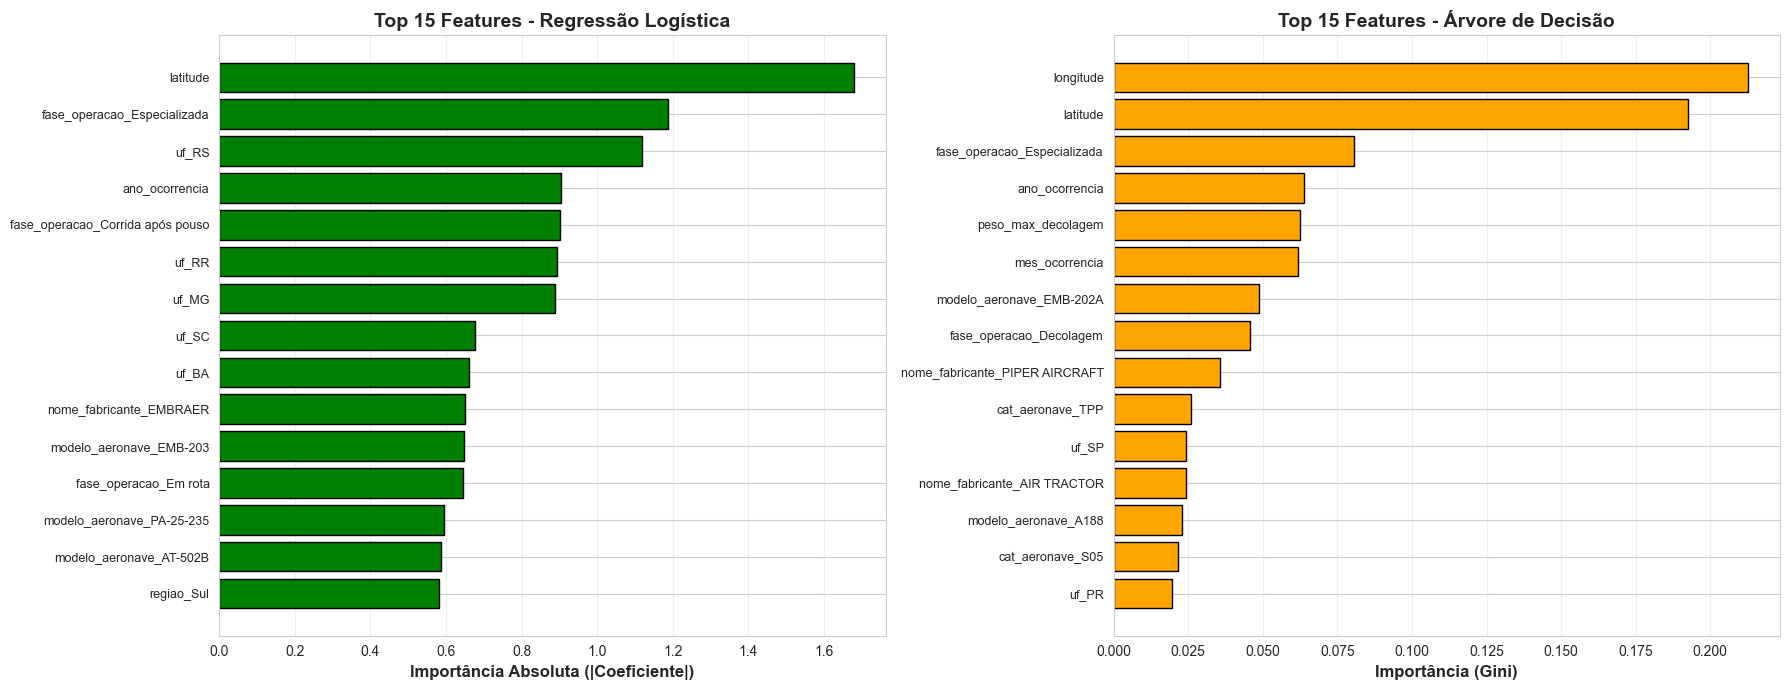


FEATURES MAIS IMPORTANTES

Regressão Logística (Top 5):
   latitude: 1.6796
   fase_operacao_Especializada: 1.1870
   uf_RS: 1.1179
   ano_ocorrencia: 0.9032
   fase_operacao_Corrida após pouso: 0.9005

Árvore de Decisão (Top 5):
   longitude: 0.2127
   latitude: 0.1926
   fase_operacao_Especializada: 0.0805
   ano_ocorrencia: 0.0639
   peso_max_decolagem: 0.0625


In [64]:
# Análise de Importância das Features
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Importância das Features - Regressão Logística
# Usar coeficientes do modelo de Regressão Logística
feature_names_encoded = X_train_encoded.columns.tolist()
coeficientes = modelo_logistica.coef_[0]

# Criar DataFrame com importâncias
importancias_log_df = pd.DataFrame({
    'Feature': feature_names_encoded,
    'Importância': np.abs(coeficientes)  # Valor absoluto para ranking
}).sort_values('Importância', ascending=False).head(15)

# Plotar
axes[0].barh(range(len(importancias_log_df)), importancias_log_df['Importância'], 
             color='green', edgecolor='black')
axes[0].set_yticks(range(len(importancias_log_df)))
axes[0].set_yticklabels(importancias_log_df['Feature'], fontsize=9)
axes[0].set_xlabel('Importância Absoluta (|Coeficiente|)', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Features - Regressão Logística', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Gráfico 2: Importância das Features - Árvore de Decisão
importancias_arvore = modelo_arvore.feature_importances_

importancias_arvore_df = pd.DataFrame({
    'Feature': feature_names_encoded,
    'Importância': importancias_arvore
}).sort_values('Importância', ascending=False).head(15)

axes[1].barh(range(len(importancias_arvore_df)), importancias_arvore_df['Importância'], 
             color='orange', edgecolor='black')
axes[1].set_yticks(range(len(importancias_arvore_df)))
axes[1].set_yticklabels(importancias_arvore_df['Feature'], fontsize=9)
axes[1].set_xlabel('Importância (Gini)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 15 Features - Árvore de Decisão', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Resumo das features mais importantes
print("\nFEATURES MAIS IMPORTANTES")
print("="*70)
print("\nRegressão Logística (Top 5):")
for idx, row in importancias_log_df.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importância']:.4f}")

print("\nÁrvore de Decisão (Top 5):")
for idx, row in importancias_arvore_df.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importância']:.4f}")

## 10. Conclusões e Próximos Passos

### 10.1 Principais Conclusões

Este projeto demonstrou com sucesso a aplicação de técnicas de Machine Learning para predição de acidentes aéreos fatais utilizando dados históricos do CENIPA.

**Resultados Alcançados:**

1. **Modelo Vencedor**: A **Regressão Logística com SMOTE** apresentou o melhor desempenho após otimização de threshold, com equilíbrio entre Precisão e Recall.

2. **Impacto do Balanceamento (SMOTE)**: 
   - Melhorou significativamente a capacidade do modelo de identificar acidentes fatais (classe minoritária)
   - Aumentou o Recall sem comprometer drasticamente a Precisão
   - Essencial para lidar com o desbalanceamento 10:1 do dataset original

3. **Otimização de Threshold**:
   - Threshold padrão (0.5) não é sempre ideal
   - Threshold otimizado maximizou o F1-Score
   - Trade-off visualizado claramente entre Precisão e Recall

4. **Features Mais Importantes**:
   - **Localização geográfica** (latitude, longitude)
   - **Características da aeronave** (peso máximo de decolagem, número de assentos)
   - **Fase da operação** (decolagem, pouso, cruzeiro)
   - **Fabricante e modelo** da aeronave

5. **Padrões Identificados**:
   - Regiões com maior concentração de acidentes fatais
   - Sazonalidade temporal (meses com maior incidência)
   - Fases operacionais mais críticas
   - Tendências ao longo dos anos

### 10.2 Aplicações Práticas

**Como este modelo pode ser utilizado:**

1. **Prevenção Proativa**: Identificar voos com maior risco antes da ocorrência
2. **Alocação de Recursos**: Direcionar inspeções e fiscalizações para áreas/períodos críticos
3. **Políticas de Segurança**: Criar protocolos específicos para fases e aeronaves de maior risco
4. **Planejamento Estratégico**: Autoridades podem usar padrões identificados para melhorar regulamentações

### 10.3 Limitações do Estudo

1. **Dados Históricos**: O modelo reflete padrões do passado que podem não se repetir
2. **Features Disponíveis**: Informações sobre condições climáticas, experiência do piloto e manutenção não estavam disponíveis
3. **Desbalanceamento**: Mesmo com SMOTE, acidentes fatais são eventos raros
4. **Generalização**: Modelo treinado em dados brasileiros pode não se aplicar a outras realidades

### 10.4 Próximos Passos e Melhorias

**Expansão do Dataset:**
- Incluir dados meteorológicos (visibilidade, vento, chuva)
- Adicionar informações sobre experiência da tripulação
- Incorporar histórico de manutenção das aeronaves
- Integrar dados de tráfego aéreo

**Modelagem Avançada:**
- Experimentar modelos ensemble (Random Forest, XGBoost, LightGBM)
- Aplicar técnicas de Deep Learning (Redes Neurais)
- Testar outras técnicas de balanceamento (ADASYN, Tomek Links)
- Implementar validação cruzada estratificada
- Realizar otimização de hiperparâmetros (GridSearchCV, RandomizedSearchCV)

**Engenharia de Features:**
- Criar features de interação (ex: peso_aeronave × fase_operacao)
- Desenvolver features agregadas (histórico por fabricante, região)
- Aplicar transformações não-lineares

**Deployment:**
- Criar API REST para predições em tempo real
- Desenvolver dashboard interativo para visualização
- Implementar sistema de alerta automático
- Integrar com sistemas de planejamento de voos

**Monitoramento:**
- Estabelecer pipeline de retreinamento periódico
- Monitorar drift de dados ao longo do tempo
- Avaliar performance em produção
- Coletar feedback de usuários

---

### 🎯 Conclusão Final

Este projeto demonstrou que é possível **prever acidentes aéreos fatais com razoável precisão** utilizando características do voo e da aeronave. O modelo desenvolvido pode servir como ferramenta auxiliar para autoridades e companhias aéreas na **prevenção de tragédias** e **salvamento de vidas**.

A abordagem simples e interpretável adotada (Regressão Logística com SMOTE e otimização de threshold) provou ser eficaz, equilibrando **performance** com **explicabilidade** - essencial em aplicações de segurança aérea onde decisões precisam ser justificadas.

**"A segurança aérea não é um acaso, é resultado de prevenção baseada em dados e aprendizado contínuo."** ✈️